In [2]:
import random
import pandas as pd
import numpy as np
from collections import namedtuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DAILY, DateFormatter, rrulewrapper, RRuleLocator, datestr2num

import pdb

### Define needed data structure

In [3]:
Measure = namedtuple('Measure', 'C1 C2, C3, C4, C5, C6, C7, C8, H1, stringency')
Tested = namedtuple('Tested', 'cumulative daily')
Confirmed = namedtuple('Confirmed', 'cumulative daily')
Combined = namedtuple('Combined', 'measure confirmed tested')

### Load the cleaned and integrated data

In [4]:
import pickle

filename = '../cleaned_integrated_data.pkl'

with open(filename, 'rb') as fp:
    loaded = pickle.load(fp)
    
print('Total number of samples: {}'.format(len(loaded)))

key = random.choice(list(loaded.keys()))
print('A random sample in the integrated dataset:')
print('key: ', key)
print('value: ', loaded[key])

Total number of samples: 4300
A random sample in the integrated dataset:
key:  (Timestamp('2020-04-17 00:00:00'), 'Uganda')
value:  Combined(measure=Measure(C1=3.0, C2=3.0, C3=2.0, C4=3.0, C5=2.0, C6=2.0, C7=2.0, C8=3.0, H1=2.0, stringency=92.59), confirmed=Confirmed(cumulative=56, daily=1), tested=Tested(cumulative=9975, daily=1120))


In [5]:
a2m = {'C1': 'C1_School closing', 'C2': 'C2_Workplace closing', 'C3': 'C3_Cancel public events', 'C4': 'C4_Restrictions on gatherings', 
       'C5': 'C5_Close public transport', 'C6': 'C6_Stay at home requirements', 'C7': 'C7_Restrictions on internal movement', 
       'C8': 'C8_International travel controls', 'H1': 'H1_Public information campaigns'}
m2a = {v: k for k, v in a2m.items()}

### Helper functions

In [6]:
from collections import OrderedDict

def search_by_country(country, dataset):
    res_by_country = dict()
    for key, value in dataset.items():
        if country in key:
            res_by_country[key] = value

    return res_by_country

def search_by_date(date, dataset):
    res_by_date = dict()
    for key, value in dataset.items():
        if date in key:
            res_by_date[key] = value

    return res_by_date

def sort_by_date(samples):
    sorted_samples = OrderedDict(sorted(samples.items(), key=lambda t: t[0][0]))

    return sorted_samples

### Visualize government measurement over time

In [7]:
import io
import requests

# Oxford Covid-19 Government Response Tracker (OxCGRT)
oxcgrt_url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
oxcgrt_data = requests.get(oxcgrt_url).content
oxcgrt_data = pd.read_csv(io.StringIO(oxcgrt_data.decode('utf-8')))

In [8]:
# select C1 to C8, H1 and Stringency Index
dc_measure_data = dict()
Measure = namedtuple('Measure', 'C1 C2, C3, C4, C5, C6, C7, C8, H1, stringency')
for index, row in oxcgrt_data.iterrows():
    value = []
    for abbr, measure in a2m.items():
        if np.isnan(row[measure]):
            value.append(None)
        else:
            value.append(row[measure])
    if np.isnan(row['StringencyIndexForDisplay']):
        value.append(None)
    else:
        value.append(row['StringencyIndexForDisplay'])

    key = (row['Date'], row['CountryName'])
    value = Measure(*value)
    dc_measure_data[key] = value

In [9]:
# statistics of some countries are not available
def check_name(name, name_list):
    names = name.split(' ')
    if len(names) == 1:
        if names[0] in name_list:
            return True, names[0]
    if len(names) == 2:
        if ' '.join(names) in name_list:
            return True, ' '.join(names)
    if len(names) >= 3:
        if ' '.join(names[0:2]) in name_list:
            return True, ' '.join(names[0:2])
        
    return False, None

In [10]:
def vis_gov_meas(date):
    res_by_date = search_by_date(int(date), dc_measure_data)

    # extract stringency and country to form a compact dataset
    country2stringency = dict()
    for key, value in res_by_date.items():
        if isinstance(value.stringency, float) or isinstance(value.stringency, int):
            country2stringency[key[1]] = value.stringency

    # load world map
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # convert from stringency to color, higher the stringency index, deeper the color
    cmap = cm.Greens
    norm = mpl.colors.Normalize(vmin=0, vmax=100)
    for key, value in country2stringency.items():
        country2stringency[key] = cmap(norm(value))[0:3]

    # set figure size
    plt.figure(figsize=(12, 16))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    name_list = list(country2stringency.keys())

    for country in shpreader.Reader(countries_shp).records():
        country_name = country.attributes['NAME']
        exist_flag, country_name = check_name(country_name, name_list)
        # country data found
        if exist_flag:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=country2stringency[country_name],
                              label=country.attributes['NAME'])
        # no data for this country
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=(1.0, 1.0, 1.0),
                              label=country.attributes['NAME'])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    plt.colorbar(sm, fraction=0.0239, pad=0.02)
    
    plt.title(date[0:4] + '-' + date[4:6] + '-' + date[6:])
    
    plt.show()

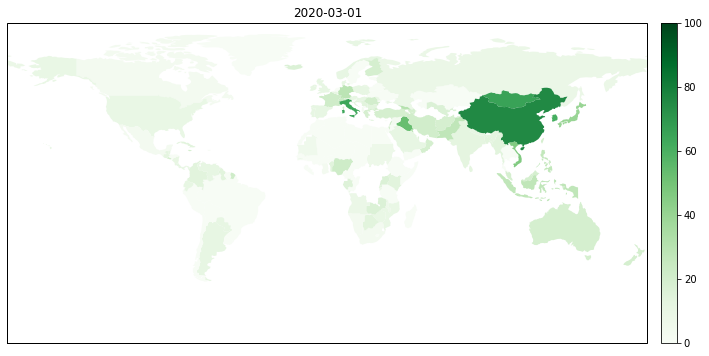

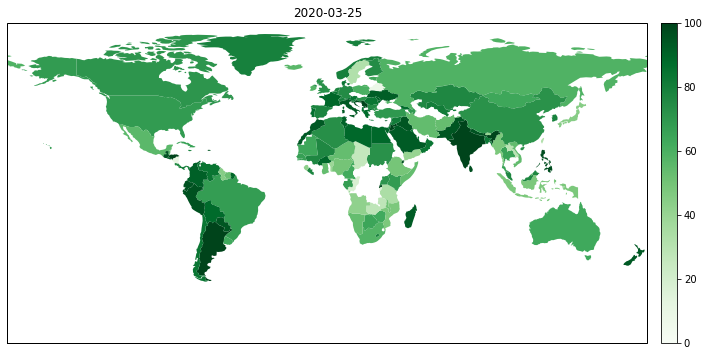

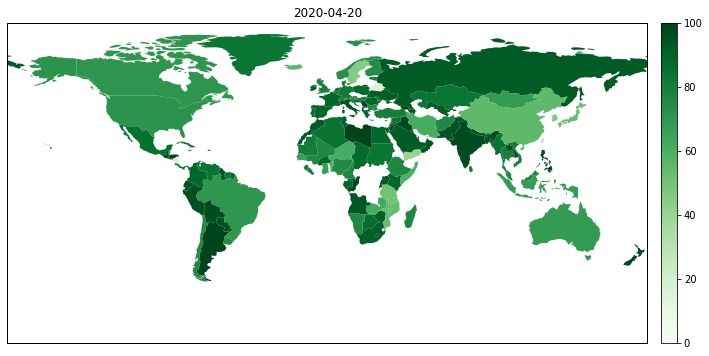

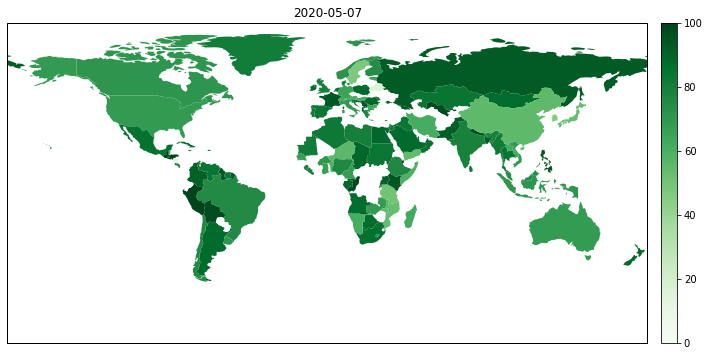

In [11]:
# ref: https://stackoverflow.com/questions/13397022/fill-countries-in-python-basemap
import itertools
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

date = '20200301'
vis_gov_meas(date)

date = '20200325'
vis_gov_meas(date)

date = '20200420'
vis_gov_meas(date)

date = '20200507'
vis_gov_meas(date)

#### Visualize confirmed cases over time

In [12]:
confirmed_url = 'https://datahub.io/core/covid-19/r/time-series-19-covid-combined.csv'
confirmed_data = requests.get(confirmed_url).content
confirmed_data = pd.read_csv(io.StringIO(confirmed_data.decode('utf-8')))

In [13]:
confirmed_data = confirmed_data.replace('US', 'United States')

dc_confirmed_dict = dict()  # 'dc' means date and country
for index, row in confirmed_data.iterrows():
    key = (row['Date'], row['Country/Region'])
    if not np.isnan(row['Confirmed']):
        if key in dc_confirmed_dict.keys():
            dc_confirmed_dict[key] = dc_confirmed_dict[key] + int(row['Confirmed'])
        else:
            dc_confirmed_dict[key] = int(row['Confirmed'])

In [14]:
import math

def vis_confirmed(date):
    res_by_date = search_by_date(date, dc_confirmed_dict)

    # extract confirmed cases and country to form a compact dataset
    country2confirmed = dict()
    for key, value in res_by_date.items():
        if isinstance(value, float) or isinstance(value, int):
            country2confirmed[key[1]] = value

    # load world map
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # convert from stringency to color, higher the stringency index, deeper the color
    cmap = cm.Blues
    norm = mpl.colors.Normalize(vmin=0, vmax=math.log(1000000))
    for key, value in country2confirmed.items():
        country2confirmed[key] = cmap(norm(math.log(value + 1e-6)))[0:3]

    # set figure size
    plt.figure(figsize=(12, 16))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    name_list = list(country2confirmed.keys())

    for country in shpreader.Reader(countries_shp).records():
        country_name = country.attributes['NAME']
        exist_flag, country_name = check_name(country_name, name_list)
        # country data found
        if exist_flag:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=country2confirmed[country_name],
                              label=country.attributes['NAME'])
        # no data for this country
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=(1.0, 1.0, 1.0),
                              label=country.attributes['NAME'])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    plt.colorbar(sm, fraction=0.0239, pad=0.02)
    
    plt.title(date[0:4] + '-' + date[4:6] + '-' + date[6:])
    
    plt.show()

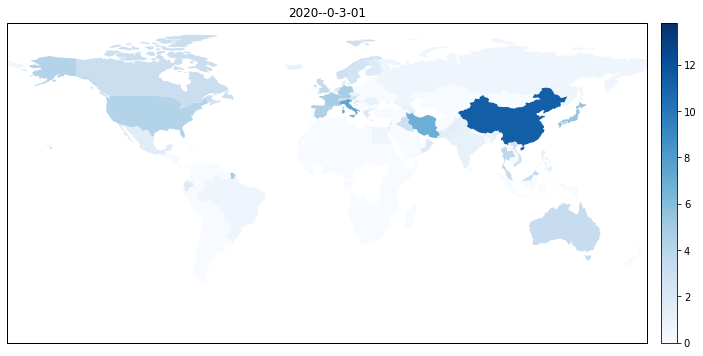

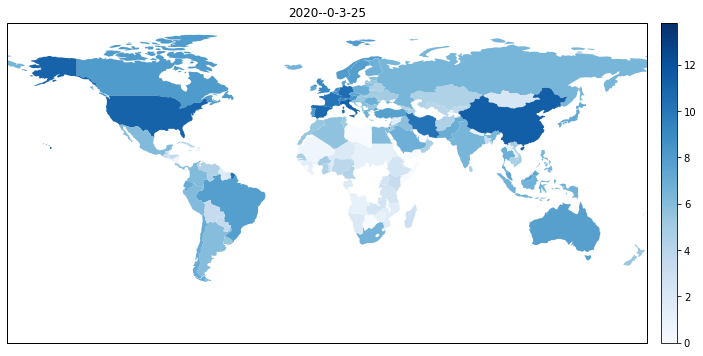

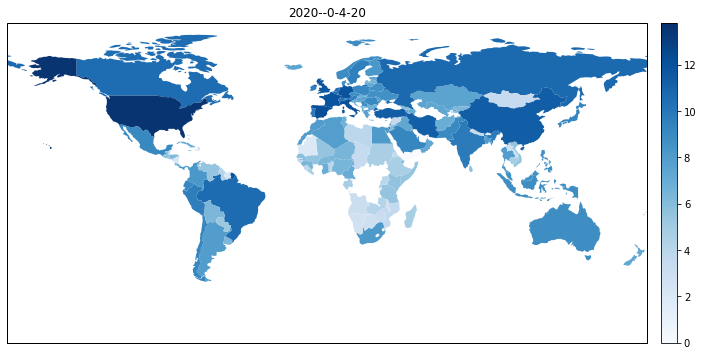

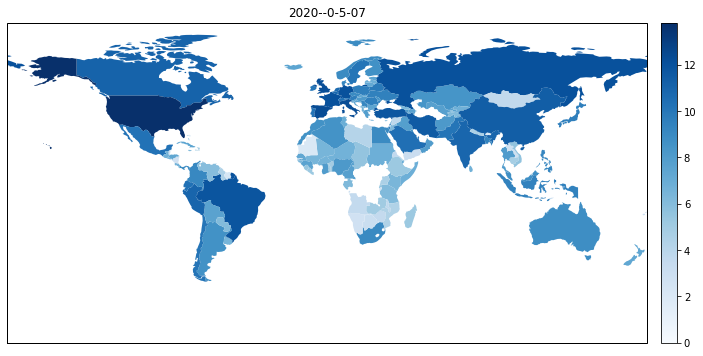

In [15]:
date = '2020-03-01'
vis_confirmed(date)

date = '2020-03-25'
vis_confirmed(date)

date = '2020-04-20'
vis_confirmed(date)

date = '2020-05-07'
vis_confirmed(date)

#### Visualize the relation between a government measurement and the confirmed ratio

In [16]:
def vis_meas_over_ratio(country, measurement):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]
    dates = datestr2num(dates)

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]

    if measurement == 'stringency':
        meas_values = [value.measure.stringency for value in sorted_samples.values()]
    else:
        meas_values = [getattr(value.measure, measurement) for value in sorted_samples.values()]

    rule = rrulewrapper(DAILY, interval=10)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')
    
    fig, ax1 = plt.subplots()
    ax1.plot_date(dates, confirmed_over_tested, 'r')
    ax1.set_ylabel('ratio', color='red')

    ax2 = ax1.twinx()
    ax2.plot_date(dates, meas_values, 'b')
    if measurement == 'stringency':
        ax2.set_ylabel('stringency', color='blue')
    else:
        ax2.set_ylabel(a2m[measurement], color='blue')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)

    plt.title(country)

    plt.show()

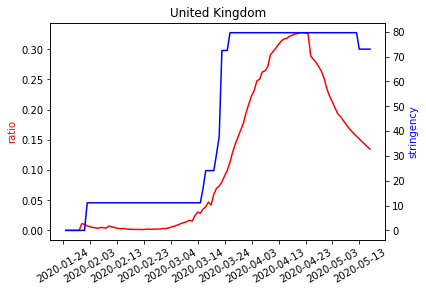

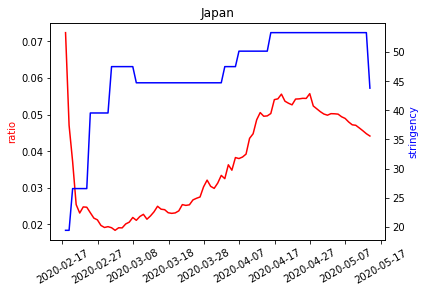

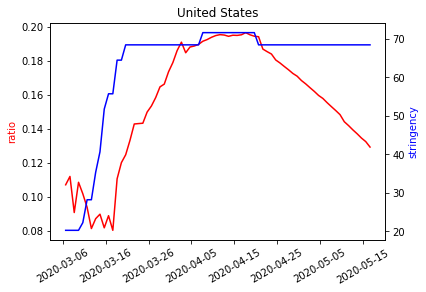

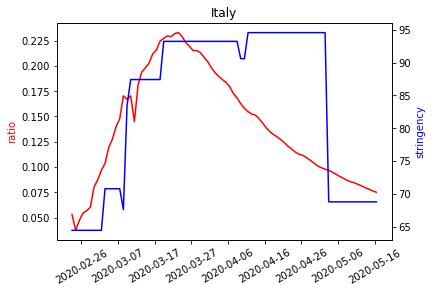

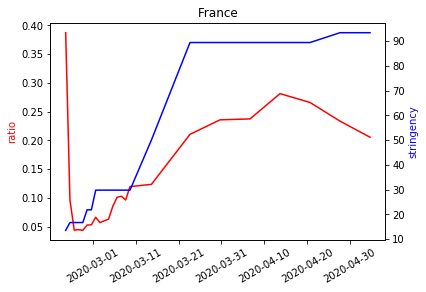

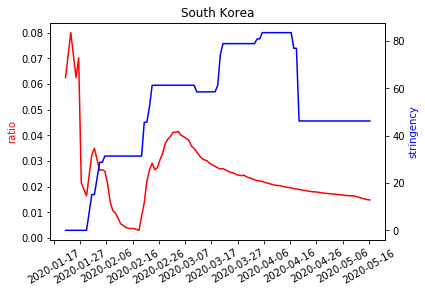

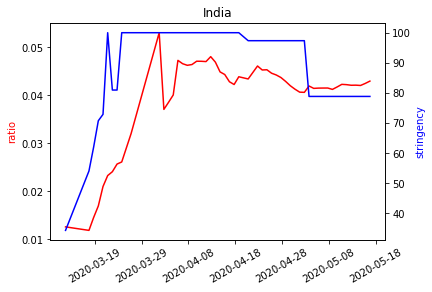

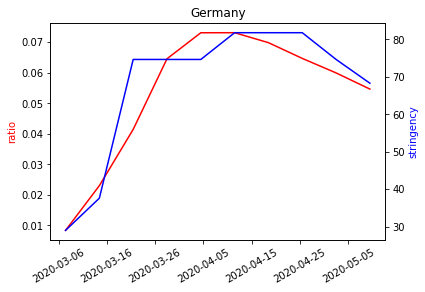

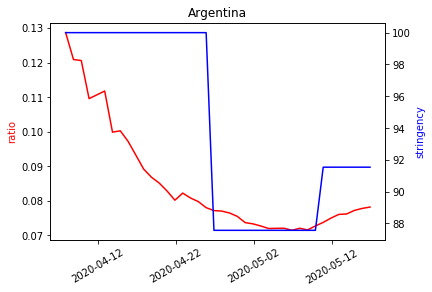

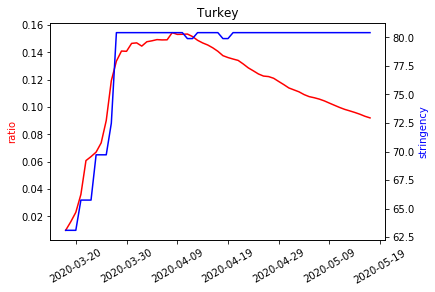

In [17]:
# select a country as an example
# ref: https://matplotlib.org/3.1.1/gallery/ticks_and_spines/date_demo_rrule.html

country = 'United Kingdom'
vis_meas_over_ratio(country, 'stringency')

country = 'Japan'
vis_meas_over_ratio(country, 'stringency')

country = 'United States'
vis_meas_over_ratio(country, 'stringency')

country = 'Italy'
vis_meas_over_ratio(country, 'stringency')

country = 'France'
vis_meas_over_ratio(country, 'stringency')

country = 'South Korea'
vis_meas_over_ratio(country, 'stringency')

country = 'India'
vis_meas_over_ratio(country, 'stringency')

country = 'Germany'
vis_meas_over_ratio(country, 'stringency')

country = 'Argentina'
vis_meas_over_ratio(country, 'stringency')

country = 'Turkey'
vis_meas_over_ratio(country, 'stringency')

#### Auto-regression model for ratio

In [18]:
from pandas.plotting import lag_plot, autocorrelation_plot
import pdb

def auto_correlation_analyze(country):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    values = pd.DataFrame(df.values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    result = dataframe.corr()
    print(result)
    
#     autocorrelation_plot(df)
#     plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(df, lags=60)
    
    plt.title(country)
    plt.show()

          t-1       t+1
t-1  1.000000  0.982958
t+1  0.982958  1.000000


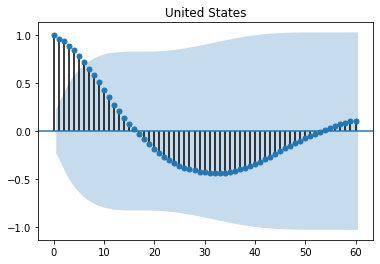

          t-1       t+1
t-1  1.000000  0.966443
t+1  0.966443  1.000000


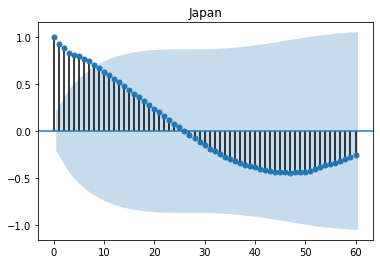

          t-1       t+1
t-1  1.000000  0.989775
t+1  0.989775  1.000000


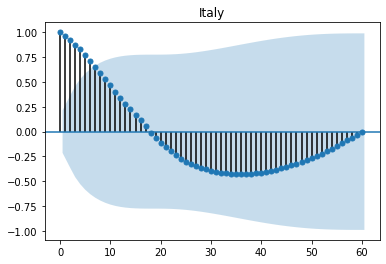

          t-1       t+1
t-1  1.000000  0.890821
t+1  0.890821  1.000000


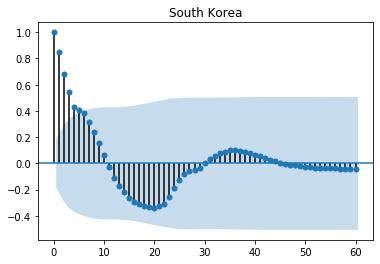

In [19]:
country = 'United States'       
auto_correlation_analyze(country)

country = 'Japan'       
auto_correlation_analyze(country)

country = 'Italy'       
auto_correlation_analyze(country)

country = 'South Korea'
auto_correlation_analyze(country)

Test MSE: 0.002806


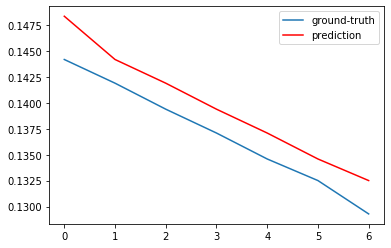

In [20]:
# predict using a baseline model which simply return the value of the previous day

from math import sqrt
from sklearn.metrics import mean_squared_error

# persistence model
def persistence_model(x):
    return x

def predict_persistent_model(country):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # create lagged dataset
    values = pd.DataFrame(df.values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']

    # split into train and test sets
    X = dataframe.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]

    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = persistence_model(x)
        predictions.append(yhat)

    rmse = sqrt(mean_squared_error(test_y, predictions))
    print('Test MSE: %.6f' % rmse)
    
    # plot predictions vs expected
    plt.plot(test_y, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    
    plt.legend()
    plt.show()
    
country = 'United States'       
predict_persistent_model(country)

In [21]:
from datetime import datetime, timedelta
from statsmodels.tsa.ar_model import AutoReg

def predict_autoregression_model(country, hyperparam):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    # train autoregression
    model = AutoReg(train, lags=hyperparam)
    model_fit = model.fit()
    print('Coefficients: %s' % model_fit.params)
    
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))

    rmse = sqrt(mean_squared_error(test, predictions))
    print('Val RMSE: %.6f' % rmse)

    # plot predictions vs expected
    plt.plot(test, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    plt.xlabel('date index')
    plt.ylabel('ratio')
    
    plt.legend()
    plt.title(country + ': val RMSE: %.6f' % rmse)
    
    # forecast for future days
    forecasts = model_fit.predict(start=len(train) + len(test), end=len(train) + len(test) + 6)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i]))
    
    future_dates = []
    for i in range(len(forecasts)):
        fd = (datetime.strptime(dates[-1], '%Y-%m-%d') + timedelta(days=1 + i)).strftime('%Y-%m-%d')
        future_dates.append(fd)
    future_dates = datestr2num(future_dates)

    # plot forecast values
    rule = rrulewrapper(DAILY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')
    
    fig, ax1 = plt.subplots()
    ax1.plot_date(future_dates, forecasts, 'r')
    ax1.set_ylabel('ratio', color='red')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    
    plt.title(country)
    plt.show()

Coefficients: [ 0.01111763  0.90265617  0.15518385  0.06963832 -0.39576855  0.30076926
 -0.12650105  0.00758564 -0.00848704  0.10416882  0.05626792  0.03505683
 -0.05896822 -0.0318681   0.05077593 -0.15317606 -0.11399558  0.21019087
  0.00854978 -0.01082199 -0.0728982 ]
predicted=0.146880, expected=0.144182
predicted=0.145356, expected=0.141898
predicted=0.144037, expected=0.139391
predicted=0.142980, expected=0.137092
predicted=0.141869, expected=0.134589
predicted=0.140994, expected=0.132508
predicted=0.140264, expected=0.129292
Val RMSE: 0.006770
forecasted=0.139417
forecasted=0.138711
forecasted=0.138070
forecasted=0.137522
forecasted=0.137162
forecasted=0.137076
forecasted=0.137103


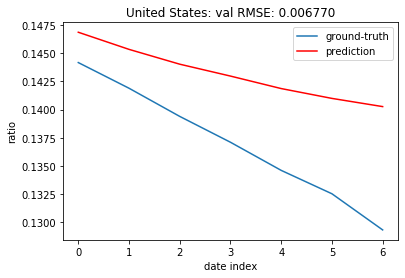

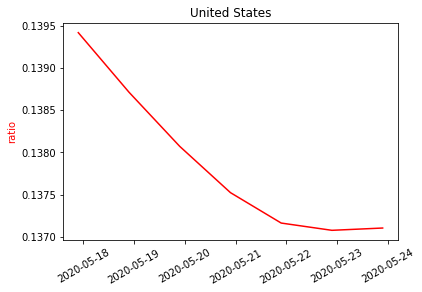

Coefficients: [ 0.00101191  0.9526852   0.14713297 -0.20709862  0.23427568 -0.17169609
  0.26757599 -0.05691713 -0.16710998 -0.02095639]
predicted=0.048598, expected=0.047995
predicted=0.048567, expected=0.047224
predicted=0.048458, expected=0.047089
predicted=0.048357, expected=0.046365
predicted=0.048053, expected=0.045605
predicted=0.047763, expected=0.044788
predicted=0.047491, expected=0.044155
Val RMSE: 0.002203
forecasted=0.047352
forecasted=0.047229
forecasted=0.047123
forecasted=0.046963
forecasted=0.046794
forecasted=0.046622
forecasted=0.046496


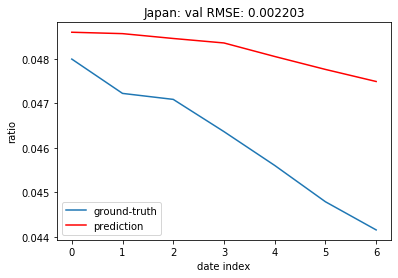

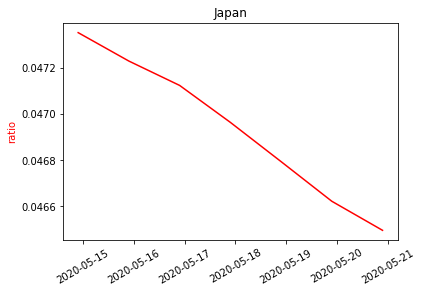

Coefficients: [ 3.26923871e-04  1.75038973e+00 -9.66191919e-01  4.24789685e-01
 -1.65617027e-01 -4.17416157e-02  7.07379673e-02 -1.70363684e-01
  1.12936024e-01 -8.46098327e-02  1.39713904e-01 -1.31443591e-01
  3.28502196e-02  8.71154045e-02 -2.00073352e-02 -2.35193942e-03
  3.17554404e-03 -1.10961075e-01  2.95054181e-02  6.77298735e-03
  2.97550061e-02]
predicted=0.084083, expected=0.084328
predicted=0.082920, expected=0.082739
predicted=0.081757, expected=0.081189
predicted=0.080527, expected=0.079464
predicted=0.079231, expected=0.077855
predicted=0.078113, expected=0.076323
predicted=0.077215, expected=0.075021
Val RMSE: 0.001279
forecasted=0.076532
forecasted=0.075852
forecasted=0.075133
forecasted=0.074333
forecasted=0.073528
forecasted=0.072788
forecasted=0.072159


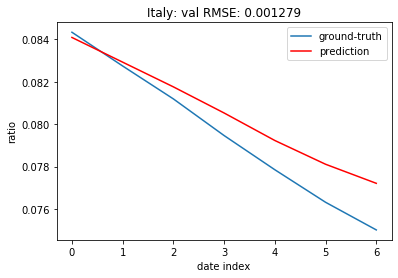

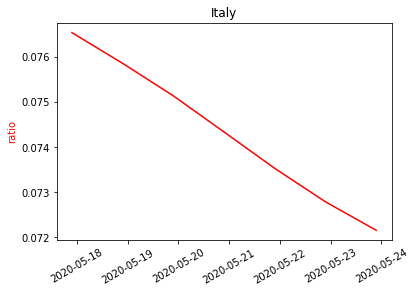

Coefficients: [ 6.12367197e-04  7.59839158e-01  7.01965991e-02 -1.31086028e-01
  3.60051469e-01  1.73316168e-01 -3.14109241e-01  7.87423816e-02
  3.39678774e-01 -5.06407102e-01 -5.90685202e-02  2.55376304e-01
 -3.70952712e-01  2.38411863e-01  2.66951189e-01 -2.04699008e-01
 -1.42265431e-01  2.59881113e-01 -7.65372248e-02 -1.57723007e-01
  1.07018722e-01  6.28941043e-02 -1.11372676e-01  6.30793199e-02
  4.65943873e-02 -5.85039568e-02 -1.89129527e-02  8.05623293e-02
 -5.19009369e-02 -3.73467651e-02  7.21595158e-02 -3.68262218e-02
 -4.58999179e-02  4.98557408e-02  8.47636859e-03 -4.16328473e-02
  1.41183120e-02  5.00714075e-02 -4.33976454e-02  1.68272372e-02
 -9.46559743e-03]
predicted=0.016362, expected=0.016359
predicted=0.016242, expected=0.016100
predicted=0.016129, expected=0.015793
predicted=0.016086, expected=0.015486
predicted=0.016001, expected=0.015187
predicted=0.015913, expected=0.014919
predicted=0.015873, expected=0.014800
Val RMSE: 0.000686
forecasted=0.015806
forecasted=0.

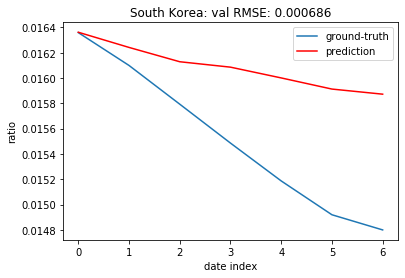

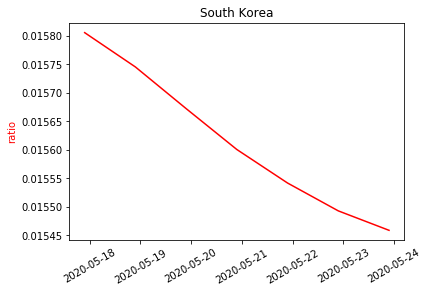

In [22]:
country = 'United States'       
predict_autoregression_model(country, hyperparam=20)

country = 'Japan'       
predict_autoregression_model(country, hyperparam=9)

country = 'Italy'       
predict_autoregression_model(country, hyperparam=20)

country = 'South Korea'       
predict_autoregression_model(country, hyperparam=40)

#### Autoregressive Moving Average Model

In [23]:
from statsmodels.tsa.arima_model import ARMA

def predict_arma_model(country, hyperparam):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    # fit model
    model = ARMA(train, order=hyperparam)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

#     # plot residual errors
#     residuals = pd.DataFrame(model_fit.resid)
#     residuals.plot()
#     plt.show()

#     residuals.plot(kind='kde')
#     plt.show()
#     print(residuals.describe())
    
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))

    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.6f' % rmse)

    # plot predictions vs expected
    plt.plot(test, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    plt.xlabel('date index')
    plt.ylabel('ratio')
    
    plt.legend()
    plt.title(country + ': val RMSE: %.6f' % rmse)
    
    # forecast for future days
    forecasts, stderr, conf_int = model_fit.forecast(steps=7)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i]))
    
    future_dates = []
    for i in range(len(forecasts)):
        fd = (datetime.strptime(dates[-1], '%Y-%m-%d') + timedelta(days=1 + i)).strftime('%Y-%m-%d')
        future_dates.append(fd)
    future_dates = datestr2num(future_dates)

    # plot forecast values
    rule = rrulewrapper(DAILY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')
    
    fig, ax1 = plt.subplots()
    ax1.plot_date(future_dates, forecasts, 'r')
    ax1.set_ylabel('ratio', color='red')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    
    plt.title(country)
    plt.show()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   64
Model:                    ARMA(10, 1)   Log Likelihood                 244.803
Method:                       css-mle   S.D. of innovations              0.005
Date:                Mon, 18 May 2020   AIC                           -463.606
Time:                        18:40:39   BIC                           -435.540
Sample:                             0   HQIC                          -452.549
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1612      0.009     17.209      0.000       0.143       0.180
ar.L1.y        0.9715      0.219      4.435      0.000       0.542       1.401
ar.L2.y        0.1693      0.230      0.737      0.4

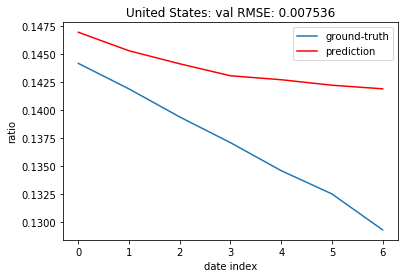

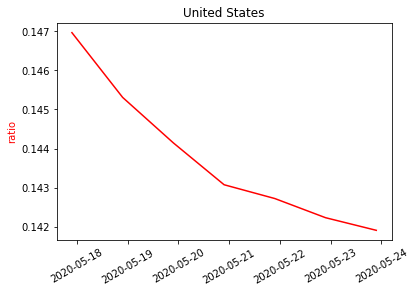

/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/a

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   79
Model:                    ARMA(20, 1)   Log Likelihood                 113.722
Method:                       css-mle   S.D. of innovations  1064101225510.565
Date:                Mon, 18 May 2020   AIC                           -181.444
Time:                        18:42:13   BIC                           -126.946
Sample:                             0   HQIC                          -159.610
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1707        nan        nan        nan         nan         nan
ar.L1.y        2.1873      0.001   3008.734      0.000       2.186       2.189
ar.L2.y       -1.3200      0.001  -1140.412      0.0

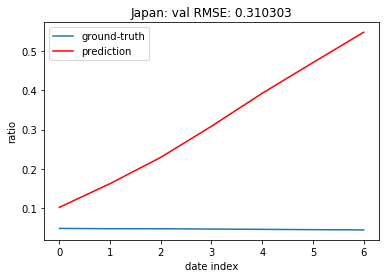

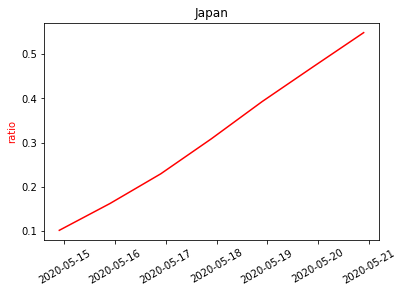

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   76
Model:                     ARMA(5, 1)   Log Likelihood                 279.700
Method:                       css-mle   S.D. of innovations              0.006
Date:                Mon, 18 May 2020   AIC                           -543.401
Time:                        18:42:44   BIC                           -524.755
Sample:                             0   HQIC                          -535.949
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1319      0.015      8.551      0.000       0.102       0.162
ar.L1.y        1.6153      0.125     12.928      0.000       1.370       1.860
ar.L2.y       -0.4884      0.211     -2.320      0.0

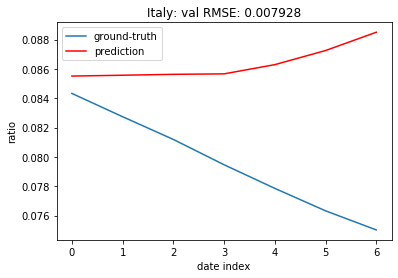

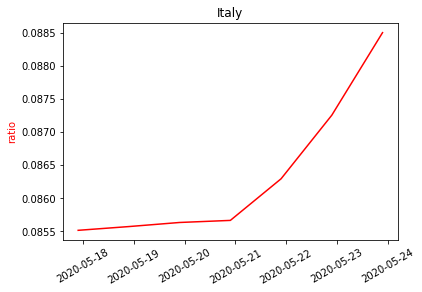

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   52
Model:                    ARMA(20, 1)   Log Likelihood                 213.211
Method:                       css-mle   S.D. of innovations              0.004
Date:                Mon, 18 May 2020   AIC                           -380.423
Time:                        18:47:55   BIC                           -335.544
Sample:                             0   HQIC                          -363.218
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1109      0.019      5.774      0.000       0.073       0.149
ar.L1.y        0.7928      0.148      5.363      0.000       0.503       1.083
ar.L2.y        0.7744      0.198      3.910      0.0

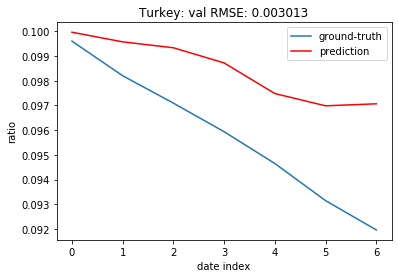

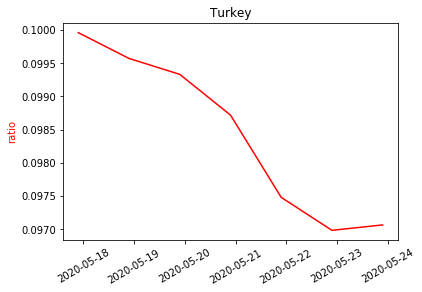

In [24]:
country = 'United States'       
predict_arma_model(country, hyperparam=(10, 1))

country = 'Japan'       
predict_arma_model(country, hyperparam=(20, 1))

country = 'Italy'       
predict_arma_model(country, hyperparam=(5, 1))

country = 'Turkey'       
predict_arma_model(country, hyperparam=(20, 1))

#### Vector Autoregression (VAR) model

In [25]:
from statsmodels.tsa.vector_ar.var_model import VAR

def predict_var_model(country, measurement, hyperparam):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    if measurement == 'stringency':
        meas_values = [value.measure.stringency for value in sorted_samples.values()]
    else:
        meas_values = [getattr(value.measure, measurement) for value in sorted_samples.values()]
        
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested, 'Measurement': meas_values}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    model = VAR(train)
    model_fit = model.fit(hyperparam)
    
    # make predictions
    predictions = model_fit.forecast(train, steps=7)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i][0], test[i][0]))
  
    rmse = sqrt(mean_squared_error(test[:, 0], predictions[:, 0]))
    print('Test RMSE: %.6f' % rmse)

    # plot predictions vs expected
    plt.plot(test[:, 0], label='ground-truth')
    plt.plot(predictions[:, 0], color='red', label='prediction')
    plt.xlabel('date index')
    plt.ylabel('ratio')
    
    plt.legend()
    plt.title(country + ': val RMSE: %.6f' % rmse)
    plt.show()

#     forecasts = model_fit.forecast(X, steps=7)
#     for i in range(len(forecasts)):
#         print('forecasted=%f' % (forecasts[i][0]))
        
     # forecast for future days
    forecasts = model_fit.forecast(X, steps=7)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i][0]))
    
    future_dates = []
    for i in range(len(forecasts)):
        fd = (datetime.strptime(dates[-1], '%Y-%m-%d') + timedelta(days=1 + i)).strftime('%Y-%m-%d')
        future_dates.append(fd)
    future_dates = datestr2num(future_dates)

    # plot forecast values
    rule = rrulewrapper(DAILY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')
    
    fig, ax1 = plt.subplots()
    ax1.plot_date(future_dates, forecasts[:, 0], 'r')
    ax1.set_ylabel('ratio', color='red')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    
    plt.title(country)
    plt.show()

predicted=0.146855, expected=0.144182
predicted=0.145043, expected=0.141898
predicted=0.143256, expected=0.139391
predicted=0.141728, expected=0.137092
predicted=0.139999, expected=0.134589
predicted=0.138507, expected=0.132508
predicted=0.136940, expected=0.129292
Test RMSE: 0.005031


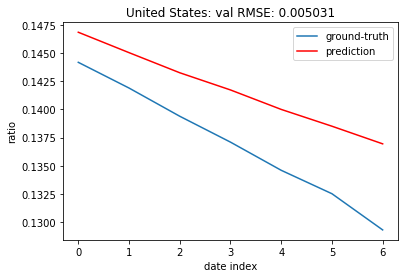

forecasted=0.128362
forecasted=0.126633
forecasted=0.124918
forecasted=0.123456
forecasted=0.121763
forecasted=0.120483
forecasted=0.119203


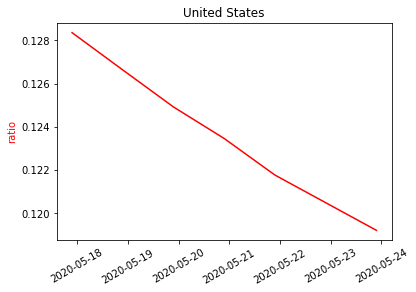

predicted=0.048509, expected=0.047995
predicted=0.048299, expected=0.047224
predicted=0.048122, expected=0.047089
predicted=0.047777, expected=0.046365
predicted=0.047182, expected=0.045605
predicted=0.046536, expected=0.044788
predicted=0.045986, expected=0.044155
Test RMSE: 0.001382


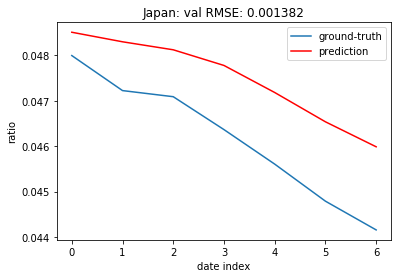

forecasted=0.040508
forecasted=0.041567
forecasted=0.037875
forecasted=0.036328
forecasted=0.035515
forecasted=0.036233
forecasted=0.034949


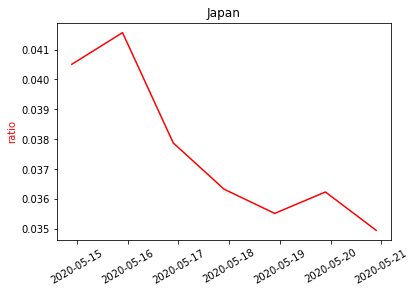

predicted=0.090631, expected=0.084328
predicted=0.095399, expected=0.082739
predicted=0.100697, expected=0.081189
predicted=0.106097, expected=0.079464
predicted=0.113789, expected=0.077855
predicted=0.120848, expected=0.076323
predicted=0.128196, expected=0.075021
Test RMSE: 0.032495


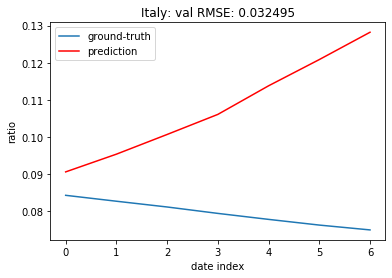

forecasted=0.080616
forecasted=0.085636
forecasted=0.091385
forecasted=0.096937
forecasted=0.104871
forecasted=0.112159
forecasted=0.119883


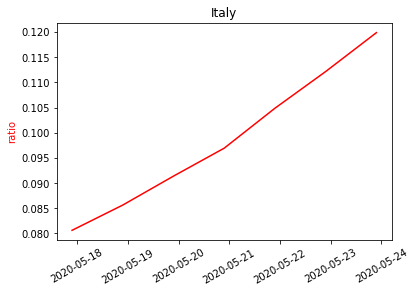

predicted=0.099153, expected=0.099600
predicted=0.096847, expected=0.098201
predicted=0.094419, expected=0.097092
predicted=0.092077, expected=0.095935
predicted=0.089793, expected=0.094648
predicted=0.087510, expected=0.093146
predicted=0.085172, expected=0.091960
Test RMSE: 0.004234


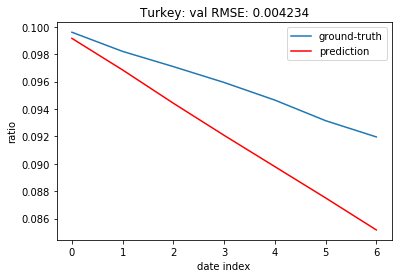

forecasted=0.089874
forecasted=0.087114
forecasted=0.084011
forecasted=0.081247
forecasted=0.078579
forecasted=0.075900
forecasted=0.073135


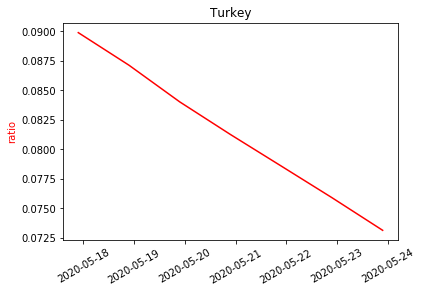

In [26]:
country = 'United States' 
measurement = 'stringency'
predict_var_model(country, measurement, 13)

country = 'Japan' 
measurement = 'stringency'
predict_var_model(country, measurement, 10)

country = 'Italy' 
measurement = 'stringency'
predict_var_model(country, measurement, 5)

country = 'Turkey' 
measurement = 'stringency'
predict_var_model(country, measurement, 5)